In [1]:
# IMPORTS

import os
from typing import List, Tuple
import numpy as np
import matplotlib.pylab as plt
import blimpy as bl
from astropy.time import Time
from astropy import units as u
import qrcode
from PIL import Image
import qrcode
from PIL import Image
%matplotlib inline

In [2]:
# CONSTANTS

MAX_IMSHOW_POINTS = (8192, 4096 / 8)
TELESCOPE = 'GBT'
OBS_TIME = '300s x 3'
COLUMN = 52

grid = plt.GridSpec(12, 6, wspace=1, hspace=0.1)

In [3]:
# FUNCTIONS

In [4]:
# The following two functions are modified versions taken from https://www.kaggle.com/tentotheminus9/l-band-2017
# Credit: Rob Harrand

def plot_waterfall(fil, f_start=None, f_stop=None, if_id=0, 
                   logged=True, cb=False, freq_label=False, MJD_time=False, **kwargs):
    """ Plot waterfall of data
    Args:
        f_start (float): start frequency, in MHz
        f_stop (float): stop frequency, in MHz
        logged (bool): Plot in linear (False) or dB units (True),
        cb (bool): for plotting the colorbar
        kwargs: keyword args to be passed to matplotlib imshow()
    """


    plt.rc('font', size=12)

    plot_f, plot_data = fil.grab_data(f_start, f_stop, if_id)

    # Make sure waterfall plot is under 4k*4k
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y =  plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]

    #print(dec_fac_x)
        
    plot_data = bl.utils.rebin(plot_data, int(dec_fac_x), int(dec_fac_y))
    
    plot_data = np.fliplr(plot_data)
    plot_f = np.flipud(plot_f)

    if MJD_time:
        extent=(plot_f[0], plot_f[-1], fil.timestamps[-1], fil.timestamps[0])
    else:
        extent=(plot_f[0], plot_f[-1], (fil.timestamps[-1]-fil.timestamps[0])*24.*60.*60, 0.0)

    this_plot = plt.imshow(plot_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
        cmap='hot',
        **kwargs
    )
    if cb:
        plt.colorbar()

    if freq_label:
        plt.xlabel("Frequency (Hz)", size=12)
    if MJD_time:
        plt.ylabel("Time (MJD)", size=12)
    else:
        plt.ylabel("Time (s)", size=12)


#    print('this is plot_data:', plot_data)
#    print('this is plot_data\'s shape:', plot_data.shape)
#    print('this is plot_f:', plot_f)
#    print('this is plot_f\'s shape', plot_f.shape)
    
    return this_plot

def make_waterfall_plots(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                         line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

#    n_plots = len(filenames_list)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(grid[i + 6, :])

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

        if i == 0:
            plt.title('Waterfall plot', size=13.5)

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + 0.1 * delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+0.1*delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f), size=12)
    

    #to plot color bar. for now.
#     fig = plt.subplots(6, sharex=True, sharey=True)
#     cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#     fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [5]:
def get_cadence_list(dirname: str) -> List[str]:
    """Return the list of cadences studied by the ML algorithm whose results are in the directory dirname.
    """

    cadence_list = []
    
    filenames = os.listdir(dirname)
    
    # There are three types of .csv files in the results directory:
        # [cadence_name].csv list the hit candidates in a cadence
        # [cadence_name]_directory.csv locate the h5 files in the Berkeley machine
        # [cadence_name]_stats_0.csv displays some info on the ML performance

    # To obtain [cadence_name]:
    for filename in filenames:
        if 'directory' not in filename and 'stats' not in filename:
            cadence_list.append(filename[:-4])
    
    return cadence_list

In [19]:
# Helper function

def get_cadence_h5files(cadence_name: str, dirname: str) -> List[str]:
    """Return the paths to the h5 files that make up cadence_name from the results directory dirname.
    """
    
    h5files = []
    
    # Add a forward slash for dirname if not included in the argument
    if dirname[-1] != '/':
        dirname += '/'
    
    filename = dirname + cadence_name + '_directory.csv'
        
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        h5file = info[1][20:]
        h5files.append(h5file)
    
    return h5files

In [7]:
# Helper function

def get_hits(cadence_name: str, dirname: str) -> List[List[float]]:
    """Return a list of sublists where each sublist is the start frequency, the end frequency, and the confidence
    of a hit candidate for cadence_name from the results directory dirname.
    """
    
    hits = []
    
    # Add a forward slash for dirname if not included in the argument
    if dirname[-1] != '/':
        dirname += '/'

    filename = dirname + cadence_name + '.csv'
 
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        start = float(info[1])
        stop = float(info[2])
        fit = float(info[3])
        hits.append([start, stop, fit])

    return hits

In [8]:
class Cadence:
    
    
    def __init__(self, cadence_name: str, dirname: str) -> None:
        
        target = cadence_name.split('-')[0]
        
        self.name = cadence_name
        self.target = target
        self.h5files = get_cadence_h5files(cadence_name, dirname)
        self.hits = get_hits(cadence_name, dirname)
        self.num_hits = len(self.hits)
    
    def __str__(self) -> str:
        
        if self.num_hits == 1:
            return 'Cadence {} with {} hit'.format(self.name, self.num_hits)
        
        return 'Cadence {} with {} hits'.format(self.name, self.num_hits)
    
    
    def get_cadence_type(self) -> str:
        """Return 'ABABAB', 'ABACAD', or 'other' depending on the cadence type. 'ABABAB' type does not 
        differentiate between cases where OFF-source is its own potential target or not.
        """        
        
        if len(self.h5files) == 6:
        
            lst = []

            for i in range(len(self.h5files)):
                fb = bl.Waterfall(self.h5files[i], load_data=False)
                source = fb.header['source_name']
                lst.append(source)

            # Check for A = A = A in ABABAB and ABACAD
            if lst[0] == lst[2] == lst[4]:
                
                # Check for B = B = B and A != B in ABABAB
                if lst[1] == lst[3] == lst[5] \
                and lst[0] != lst[1]:
                    return 'ABABAB'
                          
                # Check for B != C != D != B (non of which are A) in ABACAD
                elif lst[1] != lst[3] and lst[1] != lst[5] and lst[3] != lst[5] \
                and lst[0] != lst[1] and lst[0] != lst[3] and lst[0] != lst[5]:
                    return 'ABACAD'
        
        return 'other'
    
    
    def get_RA(self) -> str:
        """Return the right ascension of the primary target.
        """
        
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        RA = fb.header['src_raj']
        
        return str(RA)
    
    
    def get_DEC(self) -> str:
        """Return the declination of the primary target.
        """
            
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        DEC = fb.header['src_dej']
        
        return str(DEC)
    
    
    def get_date_time(self, ISOT=True) -> str:
        """Return the date and time at the start of the cadence. If ISOT is True, date format is ISO time. 
        Otherwise, date format is mean Julian day.
        """
        
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        mjd = fb.header['tstart']
        
        if ISOT:
            return Time(mjd, format='mjd').isot
        
        return str(mjd)
    
    
    def get_min_freq(self) -> str:
        """Return the minimum frequency observed in the cadence.
        """
        
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        
        if fb.header['foff'] < 0:
            min_freq = fb.container.f_start - fb.header['foff']
        else:
            min_freq = fb.container.f_start
        
        return str(min_freq) + ' MHz'
    

    def get_max_freq(self) -> str:
        """Return the maximum frequency observed in the cadence.
        """
        
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        
        if fb.header['foff'] < 0:
            max_freq = fb.container.f_stop

        else:
            max_freq = fb.container.f_stop - fb.header['foff']
        
        return str(max_freq) + ' MHz'

In [9]:
def get_num_hits_per_cadence(cadence_list: List[str], dirname: str) -> List[int]:
    """Return a list of the number of hits for each cadence in cadence_list from the results directory dirname.
    """
    
    num_hits_per_cadence = []

    for cadence_name in cadence_list:
        n = Cadence(cadence_name, dirname).num_hits
        num_hits_per_cadence.append(n)
  
    return num_hits_per_cadence

In [10]:
# Helper function

def plot_highlighted_hist(cadence: Cadence, num_hits_per_cadence: List[int]):
    """Plot a histogram of cadences based on given num_hits_per_cadence with highlighted bar designating cadence.
    """

    plt.rc('font', size=12)
    
    # Modify binning to best distribute cadences in histogram, depending on maximum number of hits for one cadence
    beyond_max = 60000
    interval = 2000
    binning = np.arange(0, beyond_max, interval)

    array, bins, patches = plt.hist(num_hits_per_cadence, bins=binning, color='gray')

    # The denominator below must match the interval in binning
    n = cadence.num_hits // interval
    patches[n].set_fc('red')

    plt.grid()
    plt.xlabel('Number of hits', size=12)
    plt.ylabel('Number of targets', size=12)
    plt.title('Hits per target', size=13.5)

In [21]:
class Hit:
    
    
    def __init__(self, cadence: Cadence, index: int) -> None:
        
        self.cadence = cadence
        self.target = cadence.target
        self.number = index + 1
        self.start_freq = cadence.hits[index][0]
        self.end_freq = cadence.hits[index][1]
        self.fit = cadence.hits[index][2]
    
    def __str__(self) -> str:
        
        return 'Hit {} of {} for cadence {}'.format(self.number, self.cadence.num_hits, self.cadence.name)
    
    
    def make_scatter_plot(self):
        """Plot frequency vs. confidence for all the hits detected for the cadence with this hit candidate 
        highlithed.
        """
        
        plt.rc('font', size=12)
        
        mid_freqs = []
        fits = []
        
        # Plot all hits in cadence
        for i in range(self.cadence.num_hits):

            mid_freq = (self.cadence.hits[i][0] + self.cadence.hits[i][1]) / 2
            fit = self.cadence.hits[i][2]
            
            mid_freqs.append(mid_freq)
            fits.append(fit)
        
        marker_size = 4 / (self.cadence.num_hits / 5000)
        
        plt.scatter(mid_freqs, fits, color='pink', marker='.', s=marker_size)
        
        # Overplot this hit
        mid = (self.start_freq + self.end_freq) / 2
        plt.plot(mid, self.fit, marker='o', color='red', ms=8)
        
        # Make the plot show the entire observing bandwidth for this cadence
        plot_start = float(self.cadence.get_min_freq()[:-4])
        plot_end = float(self.cadence.get_max_freq()[:-4])
        plt.xlim(plot_start, plot_end)
        
        plt.grid()
        plt.xlabel('Frequency (MHz)', size=12)
        plt.ylabel('Confidence', size=12)
        plt.title('Position of hit in this cadence\'s frequency band', size=13.5)
        
    
    def get_ID(self, cadence_list: List[str]) -> str:
        """Return an ID composed of two numbers separated by a dash. The first number designates the cadence in
        cadence_list, while the second number designates the hit candidate in the cadence.
        """
        
        first = str(cadence_list.index(self.cadence.name) + 1)
        second = str(self.number)
        
        ID = first.rjust(4, '0') + '-' + second.rjust(5, '0')
        
        return ID
    
    
    def generate_filename(self, cadence_list: List[str]) -> str:
        """Return a file name for the png image to created for this hit candidate from a cadence in cadence_list.
        """
        
        ID = self.get_ID(cadence_list)
        return 'hit_' + ID + '.png'
        

    def print_info(self, cadence_list: List[str], num_hits_per_cadence: List[int]) -> None:
        """Print a two-column header that describes this hit candidate with respect to the cadences in 
        cadence_list and given num_hits_per_cadence.
        """
        
        s1 = 'Target name: ' + self.target
        s2 = 'Number of hits for this cadence: ' + str(self.cadence.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Right ascension: ' + self.cadence.get_RA()
        s2 = 'Average number of hits per cadence: ' + str(round(np.mean(num_hits_per_cadence)))
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Declination: ' + self.cadence.get_DEC()
        print(s1)

        s1 = 'Telescope: ' + TELESCOPE
        print(s1)

        s1 = 'Observation start (MJD): ' + self.cadence.get_date_time(ISOT=False)
        s2 = '\t\tHit #' + str(self.number) + ' of ' + str(self.cadence.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Observation start (ISOT): ' + self.cadence.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Cadence type: ' + self.cadence.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Min frequency: ' + self.cadence.get_min_freq()
        s2 = 'Confidence: ' + str(self.fit * 100) + '%'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Max frequency: ' + self.cadence.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(cadence_list)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        
    def get_text(self, cadence_list: List[str], num_hits_per_cadence: List[int]) -> Tuple[Tuple[str]]:
        """Return a tuple of a tuple of strings describing this hit candidate with respect to the cadences in 
        cadence_list and given num_hits_per_cadence.
        """
        
        s1 = 'Target name: '
        s2 = self.target
        s3 = 'Number of hits for this cadence: ' + str(self.cadence.num_hits)
        line1 = (s1, s2, s3)
        
        s1 = 'Right ascension: ' + self.cadence.get_RA()
        s2 = 'Average number of hits per cadence: ' + str(round(np.mean(num_hits_per_cadence)))
        line2 = (s1, s2)
        
        s1 = 'Declination: ' + self.cadence.get_DEC()
        s2 = ''
        line3 = (s1, s2)

        s1 = 'Telescope: ' + TELESCOPE
        s2 = ''
        line4 = (s1, s2)

        s1 = 'Observation start (MJD): ' + self.cadence.get_date_time(ISOT=False)
        s2 = ' ' * 15 + 'Hit #' + str(self.number) + ' of ' + str(self.cadence.num_hits)
        line5 = (s1, s2)

        s1 = 'Observation start (ISOT): ' + self.cadence.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        line6 = (s1, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        line7 = (s1, s2)
        
        s1 = 'Cadence type: ' + self.cadence.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        line8 = (s1, s2)

        s1 = 'Min frequency: ' + self.cadence.get_min_freq()
        s2 = 'Confidence: ' + str(self.fit * 100) + '%'
        line9 = (s1, s2)

        s1 = 'Max frequency: ' + self.cadence.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(cadence_list)
        line10 = (s1, s2)
        
        return (line1, line2, line3, line4, line5, line6, line7, line8, line9, line10)
    
    
    def generate_QR(self, cadence_list: List[str], output_dirname=''):
        """Return a QR code encoding this hit's candidate ID, target name, start and stop frequencies, 
        path for png image, paths for each of the six h5 files that make up the cadence from cadence_list. 
        The png image will be in the directory output_dirname.
        """
        
        # Add a forward slash for non-empty output_dirname if not included in the argument
        if output_dirname != '' and output_dirname[-1] != '/':
            output_dirname += '/'
        
        ID = self.get_ID(cadence_list)
        
        line1 = 'Candidate ID: ' + ID + '\n'
        line2 = 'Target name: ' + self.target + '\n'
        line3 = 'Start frequency: ' + str(self.start_freq) + ' MHz\n'
        line4 = 'End frequency: ' + str(self.end_freq) + ' MHz\n'
        line5 = 'Image path: ' + output_dirname + 'hit_' + ID + '.png\n'
        line6 = 'Path to cadence files:'
        
        message = line1 + line2 + line3 + line4 + line5 + line6
        
        # Add one line per h5 file
        for line in self.cadence.h5files:
            message += '\n' + line
        
        img = qrcode.make(message)
        img.thumbnail((400, 400))

        return img

In [26]:
def plot_everything(this_hit: Hit, cadence_list: List[str], num_hits_per_cadence: List[int], output_dirname=''):
    """Generate an image of this_hit from a cadence in cadence_list. The image has candidate information in the 
    header (including a QR code) a histogram designating the cadence based on num_hits_per_cadence, a 
    scatter plot designating this_hit in the frequency band of the cadence, and a waterfall plot of this_hit. 
    The QR code requires the directory output_dirname to be determined.
    """
    
    
    plt.figure(figsize = (15, 20))

    # Header
    plt.subplot(grid[:3, :5])

    # The header is a subplot with no axes
    plt.axis('off')
    
    plt.text(0.48, 1, 'Candidate information', size=15, fontweight='bold')

    # Spacing between each line in the header
    spacing = 0.072
    text = this_hit.get_text(cadence_list, num_hits_per_cadence)

    for n, line in enumerate(text):
        
        # Each line is split into two columns
        
        # The first line contains the target name, which should be bold
        if n == 0:
            plt.text(-0.05, 1 - spacing * (n + 2), line[0], size=13.5)
            plt.text(0.09, 1 - spacing * (n + 2), line[1], size=13.5, fontweight='bold')
            plt.text(0.55, 1 - spacing * (n + 2), line[2], size=13.5)

        else:
            plt.text(-0.05, 1 - spacing * (n + 2), line[0], size=13.5)
            
            # The hit number will appear in the second column and should be bold
            if 'Hit' in line[1]:
                plt.text(0.55, 1 - spacing * (n + 2), line[1], size=13.5, fontweight='bold')
            else:
                plt.text(0.55, 1 - spacing * (n + 2), line[1], size=13.5)

                
    # QR code
    plt.subplot(grid[:3, 5])
    QR = this_hit.generate_QR(cadence_list, output_dirname)
    plt.imshow(QR, cmap='gray')
    plt.axis('off')
    

    # Histogram
    plt.subplot(grid[3:5, :3])
    plot_highlighted_hist(this_hit.cadence, num_hits_per_cadence)


    # Scatter plot
    plt.subplot(grid[3:5, 3:])
    this_hit.make_scatter_plot()


    # Waterfall plot
    mid = (this_hit.start_freq + this_hit.end_freq) / 2

    make_waterfall_plots(filenames_list=this_hit.cadence.h5files, target=this_hit.target, 
                         f_start=this_hit.start_freq, f_stop=this_hit.end_freq, correction_in=mid)

In [27]:
def plot_from_ID(cadence_list: List[str], dirname: str, num_hits_per_cadence: List[int], output_dirname=''):
    """Perform the function plot_everything for cadence_list, num_hits_per_cadence, and output_dirname from candidate 
    ID given by user input. Cadence must be initialized with the appropriate results directory dirname.
    """
    
    ID = input('Enter Candidate ID (two numbers separated by a dash): ')
    i = int(ID.split('-')[0]) - 1
    j = int(ID.split('-')[1]) - 1
    
    input_cadence = Cadence(cadence_list[i], dirname)
    input_hit = Hit(input_cadence, j)

    plot_everything(input_hit, cadence_list, num_hits_per_cadence, output_dirname)

In [28]:
def scatter_plot_all_hits(cadence_list: List[str], dirname: str):
    """Plot frequency vs. confidence for all the hits detected for all cadences in cadence_list. Cadences must be 
    initialized with the appropriate results directory dirname.
    """
    
    plt.rc('font', size=12)

    cadences_min_freq = []
    cadences_max_freq = []
    mid_freqs = []
    fits = []

    for cadence_name in cadence_list:
        cadence = Cadence(cadence_name, dirname)

        # Recording the extrema of the oserving frequency for each cadence
        min_freq = float(cadence.get_min_freq()[:-4])
        max_freq = float(cadence.get_max_freq()[:-4])
        cadences_min_freq.append(min_freq)
        cadences_max_freq.append(max_freq)

        for i in range(cadence.num_hits):

            mid_freq = (cadence.hits[i][0] + cadence.hits[i][1]) / 2
            fit = cadence.hits[i][2]

            mid_freqs.append(mid_freq)
            fits.append(fit)

    plt.scatter(mid_freqs, fits, color='red', marker='.', alpha=0.2, s=0.1)


    # Make the plot show the entire observing bandwidth for all cadences
    plot_start = min(cadences_min_freq)
    plot_end = max(cadences_max_freq)
    plt.xlim(plot_start, plot_end)

    plt.grid()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Confidence')
    plt.title('Position of hit in the frequency band (all cadences)')

In [29]:
def hist_all_hits(cadence_list: List[str], dirname: str):
    """Plot a histogram of all hits based on where they appear in the observing frequency of all cadences in 
    cadence_list. Cadences must be initialized with the appropriate results directory dirname.
    """

    plt.rc('font', size=12)

    cadences_min_freq = []
    cadences_max_freq = []
    mid_freqs = []

    for cadence_name in cadence_list:
        cadence = Cadence(cadence_name, dirname)

        # Recording the extrema of the oserving frequency for each cadence
        min_freq = float(cadence.get_min_freq()[:-4])
        max_freq = float(cadence.get_max_freq()[:-4])
        cadences_min_freq.append(min_freq)
        cadences_max_freq.append(max_freq)

        for i in range(cadence.num_hits):

            mid_freq = (cadence.hits[i][0] + cadence.hits[i][1]) / 2
            mid_freqs.append(mid_freq)

    # Make the plot show the entire observing bandwidth for all cadences and make small bin sizes
    plot_start = min(cadences_min_freq)
    plot_end = max(cadences_max_freq)
    freq_bins = np.arange(plot_start, plot_end + 5, 5)

    plt.hist(mid_freqs, bins=freq_bins, color='red', edgecolor='black')

    plt.grid()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Number of hits')
    plt.title('Hit distribution in the frequency band (all cadences)')

In [16]:
results = '/home/lrizk/GBT_Candidates_Explorer/Results'

In [17]:
all_cadences = get_cadence_list(results)
num_hits_list = get_num_hits_per_cadence(all_cadences, results)

Enter Candidate ID (two numbers separated by a dash): 1-1


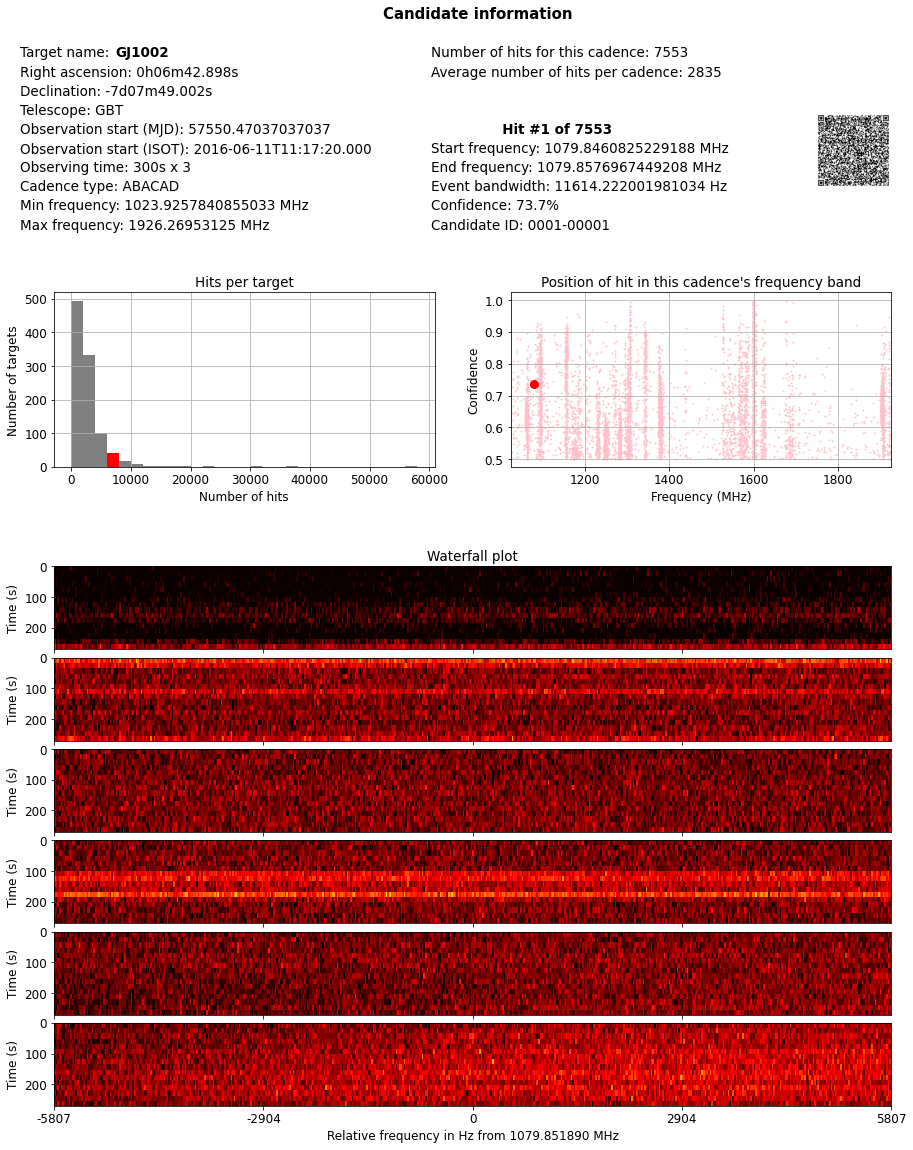

In [30]:
plot_from_ID(all_cadences, results, num_hits_list)

In [ ]:
all_cadences = get_cadence_list('/home/lrizk/GBT_Candidates_Explorer/Results/')
len(all_cadences)

In [ ]:
scatter_plot_all_hits(all_targets)

plt.gcf().set_size_inches(15, 5)    
plt.show()

In [ ]:
hist_all_hits(all_targets)

plt.gcf().set_size_inches(15, 5)    
plt.show()

In [ ]:
i = 9
j = 99

target = Target(all_targets[i])
hit = Hit(target, j)

plot_everything(hit, all_targets)

In [ ]:
plot_from_ID(all_targets)

In [ ]:
# To pick a target, redefine i or directly define target as the corresponding string:
i = 1
target = Target(all_targets[i])
#target = Target('HIP2')

In [ ]:
target.num_hits

In [ ]:
tab = ' ' * (10 - len('Hit index'))
j_list = []

print('Hit index', tab, 'Probability')
for j in range(len(target.hits)):
    if target.hits[j][2] > 0.9:
        tab = ' ' * (10 - len(str(j)))
        j_list.append(j)
        print(j, tab, target.hits[j][2])
print('\nlen =', len(j_list))

In [ ]:
k = 0

# To pick a hit, redefine j
j = j_list[k]
hit = Hit(target, j)

In [ ]:
tab = ' ' * (16 - len('Target number'))
print('Target number', tab, 'Number of 96% hits')

k_sum = 0

for i in range(len(all_targets)):
    target = Target(all_targets[i])
    
    k = 0
    for j in range(len(target.hits)):
        if target.hits[j][2] > 0.96:
            k += 1
            k_sum += 1
    
    tab = ' ' * (16 - len(str(i + 1)))
    print(i + 1, tab, k)

print('\nTotal number of 96% hits:', k_sum)

In [ ]:
# progress = 0

# for target_name in all_targets:
#     target = Target(target_name)
    
#     for j in range(len(target.hits)):
#         if target.hits[j][2] > 0.96:
#             hit = Hit(target, j)
        
#             ID = hit.get_ID(all_targets)
#             start = hit.start_freq
#             stop = hit.end_freq
#             mid = (start + stop) / 2

#             make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
#                                       f_start=start, f_stop=stop, correction_in=mid)

#             plt.suptitle('Candidate ' + ID)
#             plt.gcf().set_size_inches(12, 6)    
#             plt.savefig('../Documents/waterfall_plots_BLPC0/candidate-' + ID)
#             plt.close()

#             progress += 1
#             print(progress, '/', k_sum, 'complete.')

In [ ]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(12, 6)  
plt.show()

In [ ]:
target = Target(all_targets[0])
hit = Hit(target, 0)

In [ ]:
diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

In [ ]:
i = 4
j = 1417

target = Target(all_targets[i])
hit = Hit(target, j)

print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


plt.subplot(1, 2, 1)
plot_highlighted_hist(target)

plt.subplot(1, 2, 2)
hit.make_scatter_plot()

plt.gcf().set_size_inches(15, 5)    
plt.show()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

In [ ]:
i = 45
j = 1816

target = Target(all_targets[i])
hit = Hit(target, j)

print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


plt.subplot(1, 2, 1)
plot_highlighted_hist(target)

plt.subplot(1, 2, 2)
hit.make_scatter_plot()

plt.gcf().set_size_inches(15, 5)    
plt.show()


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots_full(filenames_list=target.cadence, target=target.name, 
                          f_start=start, f_stop=stop, correction_in=mid)

plt.suptitle('Candidate ' + hit.get_ID(all_targets))
plt.gcf().set_size_inches(15, 10)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_scatter_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq #- diff
stop = hit.end_freq #+ diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_scatter_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()

In [ ]:
print('\t\t\t\t\tCandidate information\n')

hit.print_info(all_targets)


diff = hit.end_freq - hit.start_freq

start = hit.start_freq - diff
stop = hit.end_freq + diff
mid = (start + stop) / 2

make_waterfall_plots(filenames_list=target.cadence, target=target.name, 
                     f_start=start, f_stop=stop, correction_in=mid, 
                     line1=hit.start_freq, line2=hit.end_freq)


plt.subplot(2, 2, 2)
plot_highlighted_hist(target)

plt.subplot(2, 2, 4)
hit.make_scatter_plot()

plt.gcf().set_size_inches(15, 12)    
plt.show()